### Updated code for Qualifying Exam

For this code, I wanted to finish my responses and make some changes so that I could more quickly analyze different permutations of networks. For this, I am using the Brian2 simulator instead of using the bespoke implementation of Izhikevich neurons and the synapses.

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
from collections import namedtuple
import time
from brian2 import *

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import matplotlib.cm as cm
import matplotlib.colors as c

# Own imports from utils and visualizations file
from utils import *
from visualizations import *

In [2]:
# Gathering parameters from the configuration file
# Load in the configuration dictionary
config_dict = LoadYAMLFile('config-file.yaml')
 
# For reproducibility, define a seed
seed = config_dict['general']['seed']
np.random.seed(seed)

### Parameters that won't change ###
num_groups = 3  # The number of modules in the defined space
n_dim = config_dict['general']['n_dim'] # Number of dimensions for the physical space that the neurons inhabit
radius = config_dict['general']['radius'] # Width of the physical space that the neurons can inhabit in each dimension. Equidistant in all dimensions. 

### Parameters for implementing modules ###
n = config_dict['general']['n'] # The number of neurons in the default network
n_per_group = config_dict['general']['n_per_group'] # Number of neurons in each module if that exists
module_std = config_dict['general']['module_std'] # The standard deviation of the node positions within a module
x1_mean = config_dict['general']['x1_mean'] # Center in x dimension for 3 modules
x2_mean = config_dict['general']['x2_mean']
x3_mean = config_dict['general']['x3_mean']
y1_mean = config_dict['general']['y1_mean'] # Center in y dimension for 3 modules
y2_mean = config_dict['general']['y2_mean']
y3_mean = config_dict['general']['y3_mean']
num_rich_club_neurons_per_module = config_dict['general']['num_rich_club_neurons_per_module'] # The number of connections "rich-club" neurons in each module

### Connection Types ###
distance_connection_probability_exponent_constant = config_dict['general']['distance_connection_probability_exponent_constant']
constant_connection_probability = config_dict['general']['constant_connection_probability']
constant_weight_value = config_dict['general']['constant_weight_value']
mean_weight_val = config_dict['general']['mean_weight_val']
std_weight_val = config_dict['general']['std_weight_val']

### Inputs to the Network ###
number_of_rich_club_neurons_to_stimulate = config_dict['general']['number_of_rich_club_neurons_to_stimulate'] # The number of rich club neurons to stimulate
q = config_dict['general']['q'] # The frequency of random spiking (seconds)
num_neurons_to_stimluate = 10 # Number of neurons to stimulate if constant injection to a subset

### Timing parameters ###
num_time_steps = config_dict['timing']['num_time_steps']
t_step_size = float(config_dict['timing']['t_step_size'])

### Inidivudal neuron dynamics ###  
resting_voltage = config_dict['izhikevich']['rmv'] # Resting membrane potential to start
default_a = config_dict['izhikevich']['default_a'] # The default Izhikevich A value
default_b = config_dict['izhikevich']['default_b'] # The default Izhikevich B value
default_c = config_dict['izhikevich']['default_c'] # The default Izhikevich C value
default_d = config_dict['izhikevich']['default_d'] # The default Izhikevich D value
superthreshold_injected_current = config_dict['izhikevich']['superthreshold_injected_current'] # The amount of injected current for external stimulation
highest_injected_current = config_dict['izhikevich']['highest_injected_current'] # The amount of injected current along edges
injected_current_decay_parameter = config_dict['general']['injected_current_decay_parameter'] # How the injected current is decaying

### PCA ###
gaussian_filter_sigma = config_dict['general']['gaussian_filter_sigma'] # The sigma value for the gaussian filter of the voltage time series

### Booleans that won't change ###
check_distance_matrix_symmetry = False # This was for testing, not needed for now
save_outputs = True # We want to save the results each time

### Booleans for Visualizations ###
visualize_nodal_positions_without_edges = False 
visualize_adjacency_matrix = True
visualize_connected_network = True
visualize_spike_trace = False
visualize_voltage_trace = True
diagnostic_printing = False

### Image Paths ###
figures_base_path = 'updated-figures/'

# Print out all of the assumed values here
print(f'''
PARAMETERS OF THE SYSTEM FROM CONFIGURATION DICTIONARY

# Parameters that won't change
Number of Modules: {num_groups}
Number of Dimensions: {n_dim}

# Parameters for implementing modules
Number of Neurons per Module: {n_per_group}
Standard Deviation of Position within Modules: {module_std}
Module 1 X Dimension Mean: {x1_mean}
Module 2 X Dimension Mean: {x2_mean}
Module 3 X Dimension Mean: {x3_mean}
Module 1 Y Dimension Mean: {y1_mean}
Module 2 Y Dimension Mean: {y2_mean}
Module 3 Y Dimension Mean: {y3_mean}
Number of "rich-club" neurons per Module: {num_rich_club_neurons_per_module}

# Connection Types
Exponent to vary connection probability based on distance: {distance_connection_probability_exponent_constant}
Constant Connection Probabiltiy if not Dependent on Distance: {constant_connection_probability}
Value for Weights Between Neurons When Set Constant: {constant_weight_value}
Mean value for Weights: {mean_weight_val}
Standard deviation for weights: {std_weight_val}

# Inputs to the Network
Frequency of Random Spiking from external stimuli (q): {q}
The number of neurons to actively stimulate: {number_of_rich_club_neurons_to_stimulate}
Number of neurons to randomly stimulate: {num_neurons_to_stimluate}

# Timing parameters
Total Number of Time Steps: {num_time_steps}
Change in t for each step (seconds): {t_step_size}

# Inidivudal neuron dynamics
Resting Membrane Potential: {resting_voltage}
Izhikevich A Parameter: {default_a}
Izhikevich B Parameter: {default_b}
Izhikevich C Parameter: {default_c}
Izhikevich D Parameter: {default_d}
Superthreshold Injected Current Value: {highest_injected_current}
Injected Current Decay Parameter: {injected_current_decay_parameter}

# PCA
Sigma Value for the Gaussian Filter: {gaussian_filter_sigma}

# Booleans for visualizations
Visualize Node Positions Without Edges: {visualize_nodal_positions_without_edges}
Visualize Adjacency Matrix: {visualize_adjacency_matrix}
Visualize Connected Network (nodes and edges): {visualize_connected_network}
Visualize Spike Trace: {visualize_spike_trace}
Visualize Voltage Trace: {visualize_voltage_trace}
Diagonastic Printing: {diagnostic_printing}
''')


PARAMETERS OF THE SYSTEM FROM CONFIGURATION DICTIONARY

# Parameters that won't change
Number of Modules: 3
Number of Dimensions: 2

# Parameters for implementing modules
Number of Neurons per Module: 100
Standard Deviation of Position within Modules: 0.1
Module 1 X Dimension Mean: 0.9
Module 2 X Dimension Mean: 0.6
Module 3 X Dimension Mean: 0.9
Module 1 Y Dimension Mean: 0.3
Module 2 Y Dimension Mean: 0.6
Module 3 Y Dimension Mean: 0.9
Number of "rich-club" neurons per Module: 1

# Connection Types
Exponent to vary connection probability based on distance: 20
Constant Connection Probabiltiy if not Dependent on Distance: 0.03
Value for Weights Between Neurons When Set Constant: 0.1
Mean value for Weights: 0.5
Standard deviation for weights: 0.05

# Inputs to the Network
Frequency of Random Spiking from external stimuli (q): 0
The number of neurons to actively stimulate: 1
Number of neurons to randomly stimulate: 10

# Timing parameters
Total Number of Time Steps: 10000
Change in t fo

Network Density: 3.11%
Adjacency Matrix:


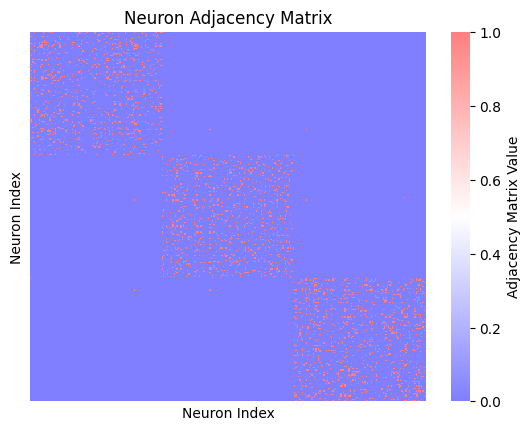



Network Configuration:


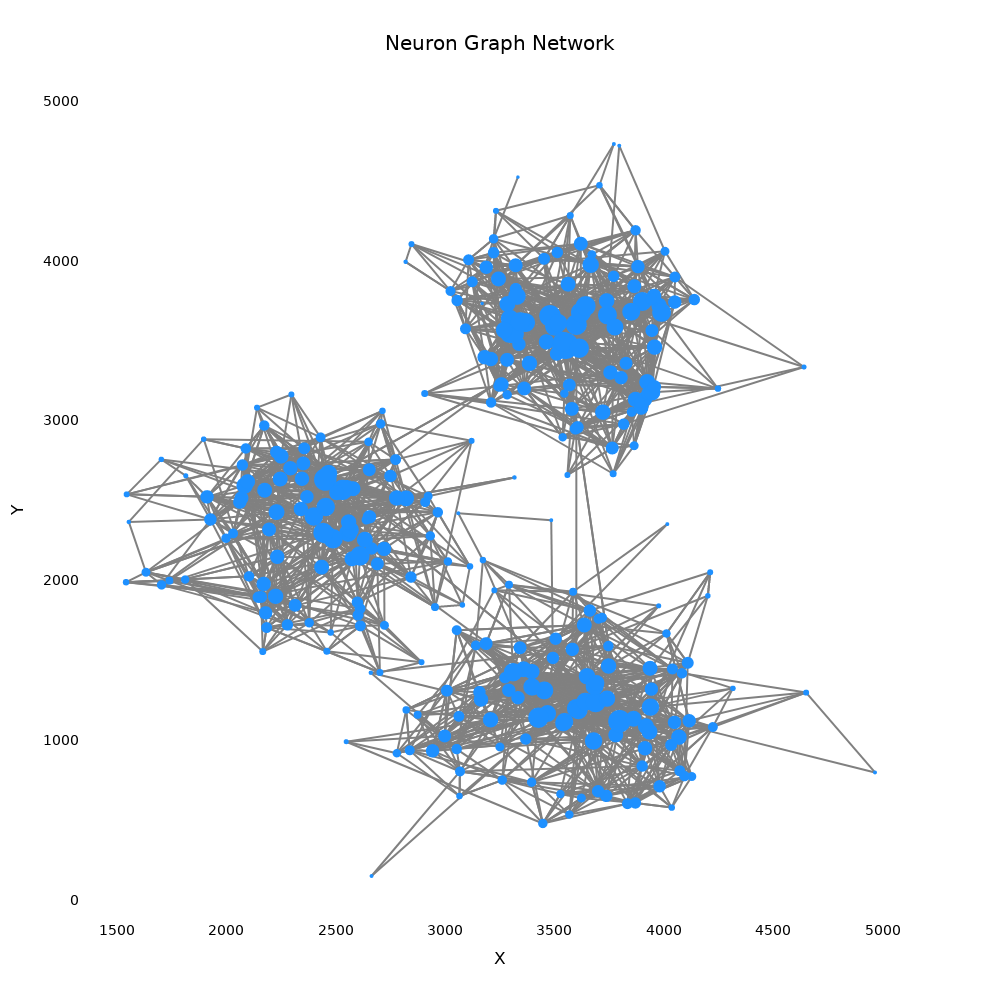

In [3]:
array_id = 4

# Booleans for creating the network
implement_nueron_modules_positions = True # We want to test without modules right now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity to selected axons
implement_timing = True # This will be tested later
implement_constant_weights = False # Weights will be drawn from a normal distribution
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # constant_connection_probability # We care about distance now, so remove constant_connection_probability

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

distance_connection_probability_exponent_constant_for_modules = 28

# Creating the positions array
pos_array = GeneratePosArray(
        implement_nueron_modules_positions,
        n_dim = n_dim,
        radius = radius,
        n = n,
        num_groups = num_groups,
        n_per_group = n_per_group,
        seed = seed,
        std = module_std,
        x1_mean = x1_mean, 
        x2_mean = x2_mean,
        x3_mean = x3_mean,
        y1_mean = y1_mean,
        y2_mean = y2_mean,
        y3_mean = y3_mean, 
)

# Re-introduce n into the scope in case modules have been created
n = pos_array.shape[0]

# Calculate the euclidean distance between all nodes
distance_matrix = GetDistanceMatrix(
    pos_array = pos_array,
    n_dim = n_dim,
    check_symmetry = check_distance_matrix_symmetry
)

# Define the adjacency matrix and edges of the network
A, edges, rich_club_neurons = GetAdjacencyMatrix(
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    distance_matrix = distance_matrix,
    pos_array = pos_array,
    radius = radius,
    n_dim = n_dim,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    n_per_group = n_per_group,
    num_groups = num_groups,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability
)

### Setting Up Neurons

In [12]:
# Working out this function
def Brian2SimulateNeurons(
    pos_array,
    edges,
    config_dict,
    weights, 
    implement_timing,
    constant_diameter,
    myelinated_index,
    constant_injected_current_index_seed,
    num_neurons_to_stimluate,
):
    '''
    A function to use the Brian2 Simulation method for 

    constant_injected_current_index_seed: Seed to be used when constantly stimulating a subset of neurons
    '''

    start_scope()

    # Changing the default clock so that the dt is 0.01 instead of 0.1
    num_time_steps = 100000
    dt = 0.01
    defaultclock.dt = dt*ms
    
    # Excitatory Parameters
    spike_threshold = 30*mV
    a = 0.02/ms
    b = 0.2/ms
    c = -65*mV
    d = 8*mV/ms
    
    # Conductance changes
    # Values for these conductances taken from https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_1_COBA.html
    E_e = 0*mV 
    E_i = -80*mV 
    tau_e = 5*ms
    tau_i = 10*ms
    tau_r = 5*ms # A refractory period
    C_m = 198*pF           # Membrane capacitance
    w_e = 23*nS # 0.05*nS          # Excitatory synaptic conductance
    w_i = 20*nS # 1.0*nS           # Inhibitory synaptic conductance
        
    eqs = '''
    dv/dt = (0.04/ms/mV)*v**2+(5/ms)*v+140*mV/ms-u+ (I_syn+I_ext) / C_m: volt
    du/dt = a*(b*v-u) : volt/second 
    I_syn = g_e * (E_e - v) + g_i * (E_i - v) : amp
    dg_e/dt = -g_e / tau_e: siemens
    dg_i/dt = -g_i / tau_i: siemens
    I_ext : amp
    '''
    
    # The reset of the dynamics after a spike
    reset = '''
    v = c
    u = u + d
    '''
    
    # Creating the network
    G = NeuronGroup(n, eqs, threshold=f'v >= spike_threshold', reset=reset, method='euler')
    G.v = c # Setting the resting potentials
    G.u = b * G.v # Setting the resting value of u
    G.g_e = 0*nS # Setting the deaful
    G.g_i = 0*nS 
    
    # Set up dynamic clipping, don't want the conductance values to reach unrealisitc values
    G.run_regularly('g_e = clip(g_e, 0*nS, 30*nS)', dt=defaultclock.dt)
    G.run_regularly('g_i = clip(g_i, 0*nS, 50*nS)', dt=defaultclock.dt)

    # Apply injected current to neurons
    np.random.seed(constant_injected_current_index_seed)
    constant_injected_current_index = np.random.choice(
        np.arange(n), num_neurons_to_stimluate, 
        replace = False
    )

    # Set external activity, equivalent to 7.5 mV
    G.I_ext = 0*pA
    G.I_ext[constant_injected_current_index] = 1485*pA
    
    # Creating synapses
    if not implement_timing:
        S = Synapses(G, G, '''w : 1''', on_pre='g_e_post += w*w_e')
        S.connect(i = edges[:, 0], j = edges[:, 1])

    # When adding conductance delays
    if implement_timing:
        
        time_to_complete_ap = PosArray_to_SignalTiming(
            pos_array, edges, config_dict, 
            constant_diameter, myelinated_index
        )
    
        # Have to change the results so that the timings are on correct scale
        time_to_complete_ap = (time_to_complete_ap) * ms
    
        # Create the synapses
        S = Synapses(G, G, '''w : 1''', on_pre='g_e_post += w*w_e')
        S.connect(i = edges[:, 0], j = edges[:, 1])
    
        # Implement conduction delays
        S.delay = time_to_complete_ap

    # Implement the weights
    S.w = weights[edges[:, 0], edges[:, 1]]
    
    # group.v = 'rand()'
    state = StateMonitor(G, 'v', record = True)
    
    # Run a network
    run(num_time_steps*dt*ms)
    
    # Way to get the voltages out and make them 
    voltages = np.array(state.v.T) * 1000 # Sending to mV instead of Volts
    
    # Create the out named tuple
    out = CreateNamedTuple(
        voltages,
        t_step_size = dt,
        num_time_steps = num_time_steps
    )

    return out

### Example Changes as a Result of Changes in Conduction Velocity

Trajectory Number: 0


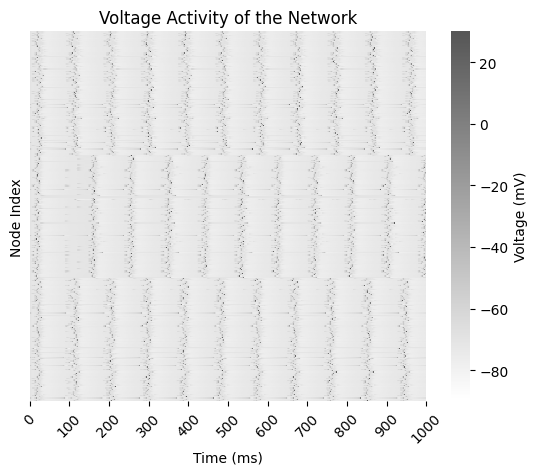

Trajectory Number: 1


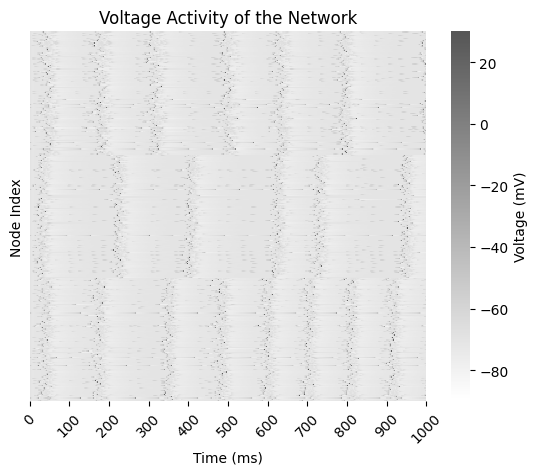

Trajectory Number: 2


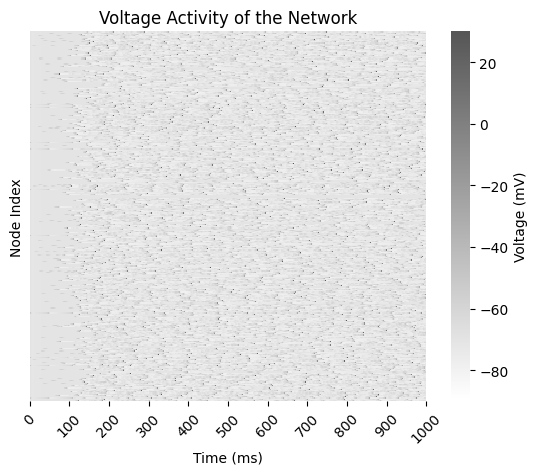

In [4]:
weights = weight_adjustement = np.random.normal(loc = 1, scale = 0, size = (n,n))
implement_timing = True
constant_diameter = None
myelinated_index = None
constant_injected_current_index_seed = 2302
num_neurons_to_stimluate = 10
num_trajectories = 5


config_dict['general']['num_time_steps'] = 100000
# config_dict['g-ratio']['theta_scalar_myelin'] = config_dict['g-ratio']['theta_scalar_non_myelin'] = 0.005

theta_scalars = [0.05, 0.005, 0.0005]

np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

for i, theta_scalar in enumerate(theta_scalars):
    print(f'Trajectory Number: {i}')

    config_dict['g-ratio']['theta_scalar_myelin'] = config_dict['g-ratio']['theta_scalar_non_myelin'] = theta_scalar

    voltage_trace_path = f'updated-figures/conduction-velocity-test/theta-scalar-{i}.png'
    
    out = Brian2SimulateNeurons(
        pos_array = pos_array,
        edges = edges,
        config_dict = config_dict,
        weights = weights,
        implement_timing = True,
        time_to_complete_ap = None, 
        constant_injected_current_index = constant_injected_current_index,
    )

    # Plot the voltage
    PlotVoltageTrace(
        out, flip_axes=True, 
        include_node_indices=False,
        cmap = 'grey_r',
        save_graphic_path = voltage_trace_path
    )


##### An attempt at multiple trajectories in same space

In [ ]:
# Define trajectories
trajectories = [x.voltages for x in outs]

# Have to gaussian smooth trajectories before going in function
for i, x in enumerate(trajectories):
    print(f'Trajectory: {i}')
    x = gaussian_filter1d(x, sigma=gaussian_filter_sigma*10, axis=0)
    trajectories[i] = x

Trajectory: 0
Trajectory: 1
Trajectory: 2


In [8]:
stacked_trajectories = np.concat(trajectories)

In [9]:
PCA(stacked_trajectories, 2, )

array([[-65.        , -65.        , -65.        , ..., -65.        ,
        -65.        , -65.        ],
       [-65.03      , -65.03      , -65.03      , ..., -64.955     ,
        -65.03      , -65.03      ],
       [-65.05993964, -65.05993964, -65.05993964, ..., -64.91008919,
        -65.05993964, -65.05993964],
       ...,
       [-70.06694734, -71.19411431, -70.65603757, ..., -68.86520354,
        -69.04839984, -66.80139745],
       [-70.05359016, -71.19386679, -70.65587036, ..., -68.87570816,
        -69.04146084, -66.81391459],
       [-70.04050942, -71.19361925, -70.65570319, ..., -68.88625799,
        -69.03473697, -66.82650022]], shape=(500000, 300))

In [ ]:
out.num_time_steps / 1000

In [ ]:
# View PCA
x_reduced, eig, eigvec = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma*10)
PlotExplainedVariance(eig, file_save_path = None)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, None)

In [ ]:
PlotIndividualNodeTrace(
    out,
    node_index = 11
)

In [ ]:
edges

### Updated Dynamics Examples

Network Density: 2.91%
Adjacency Matrix:


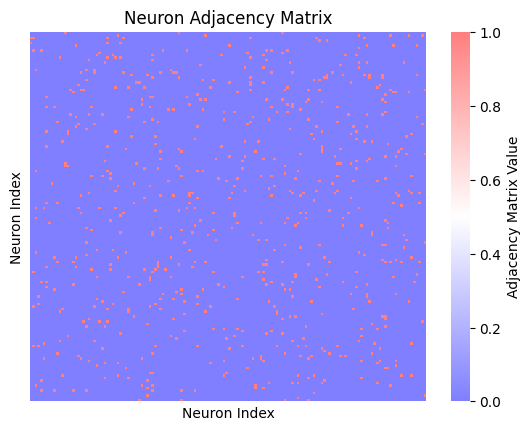



Network Configuration:


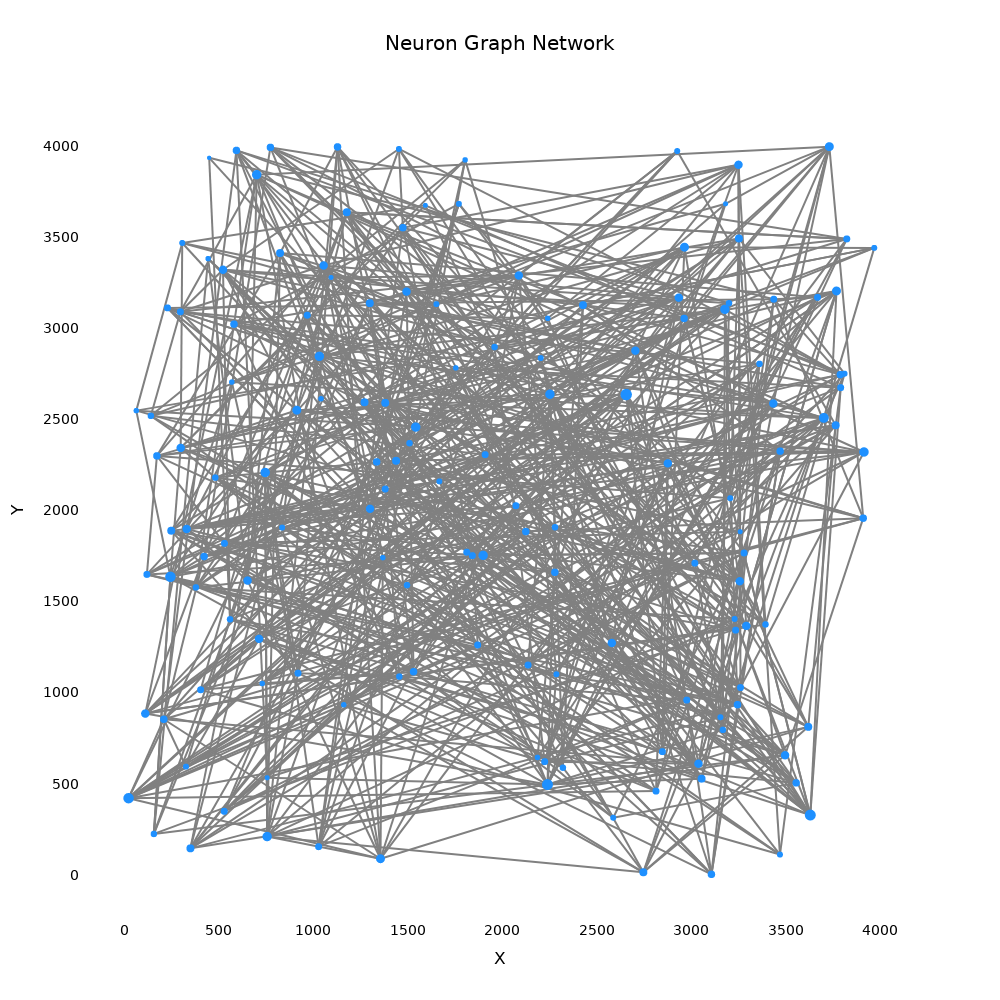

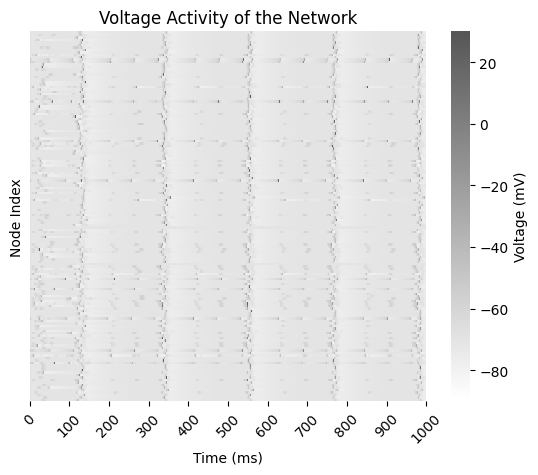

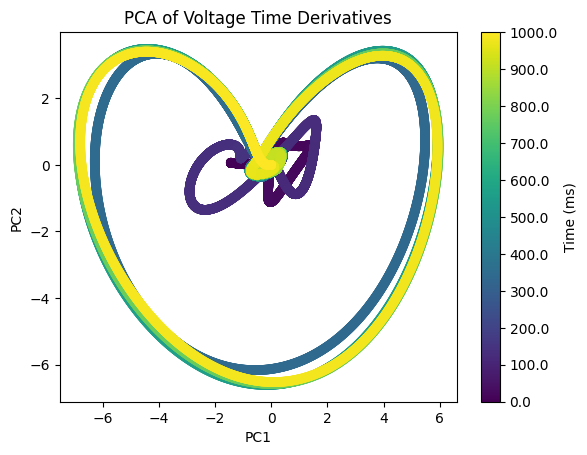

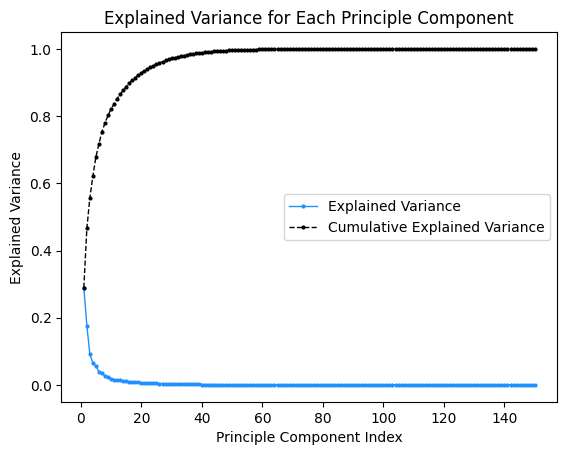

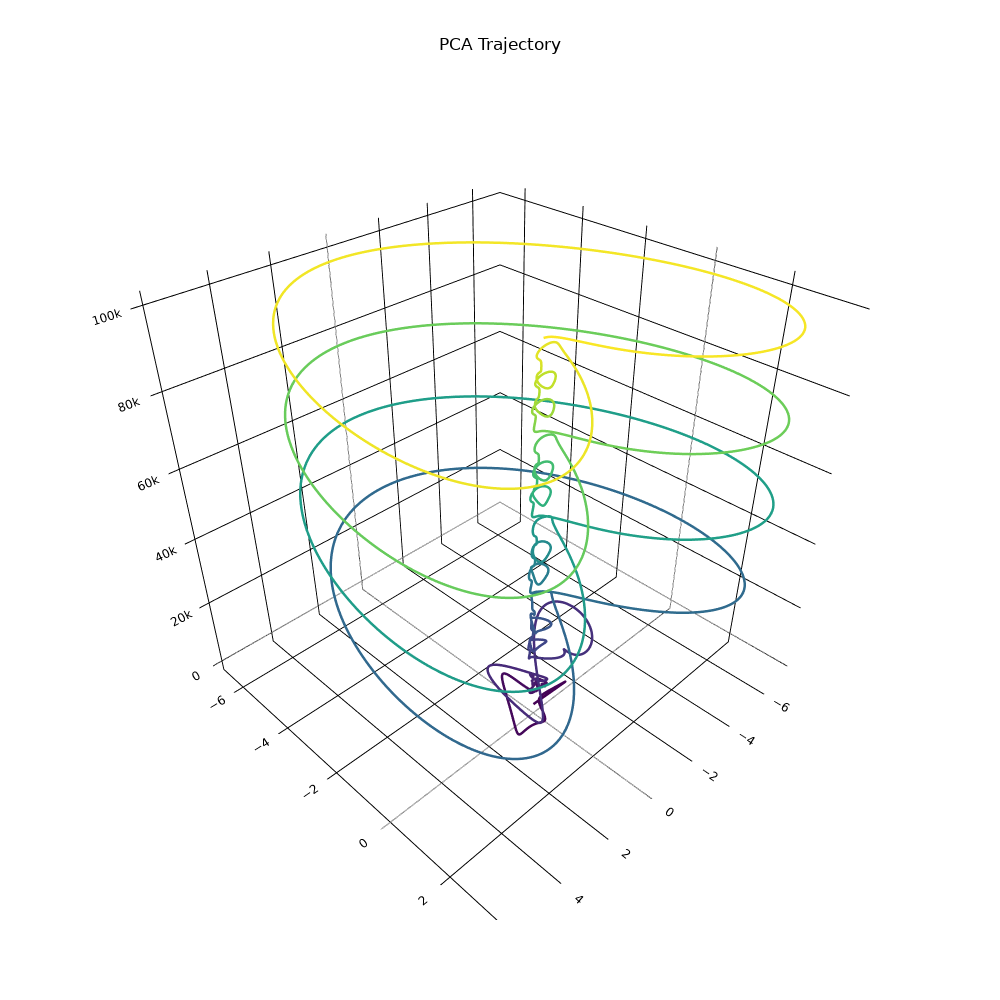

In [3]:
# Define an array ID so that I can save the data under this concept
array_id = 1
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test without modules right now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = config_dict['general']['constant_connection_probability']
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = False

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = False,
    time_to_complete_ap = None,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 2.59%
Adjacency Matrix:


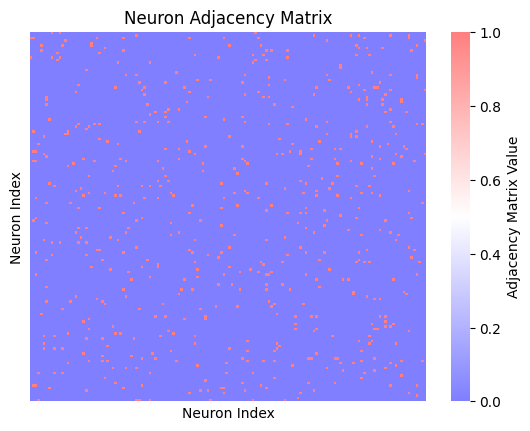



Network Configuration:


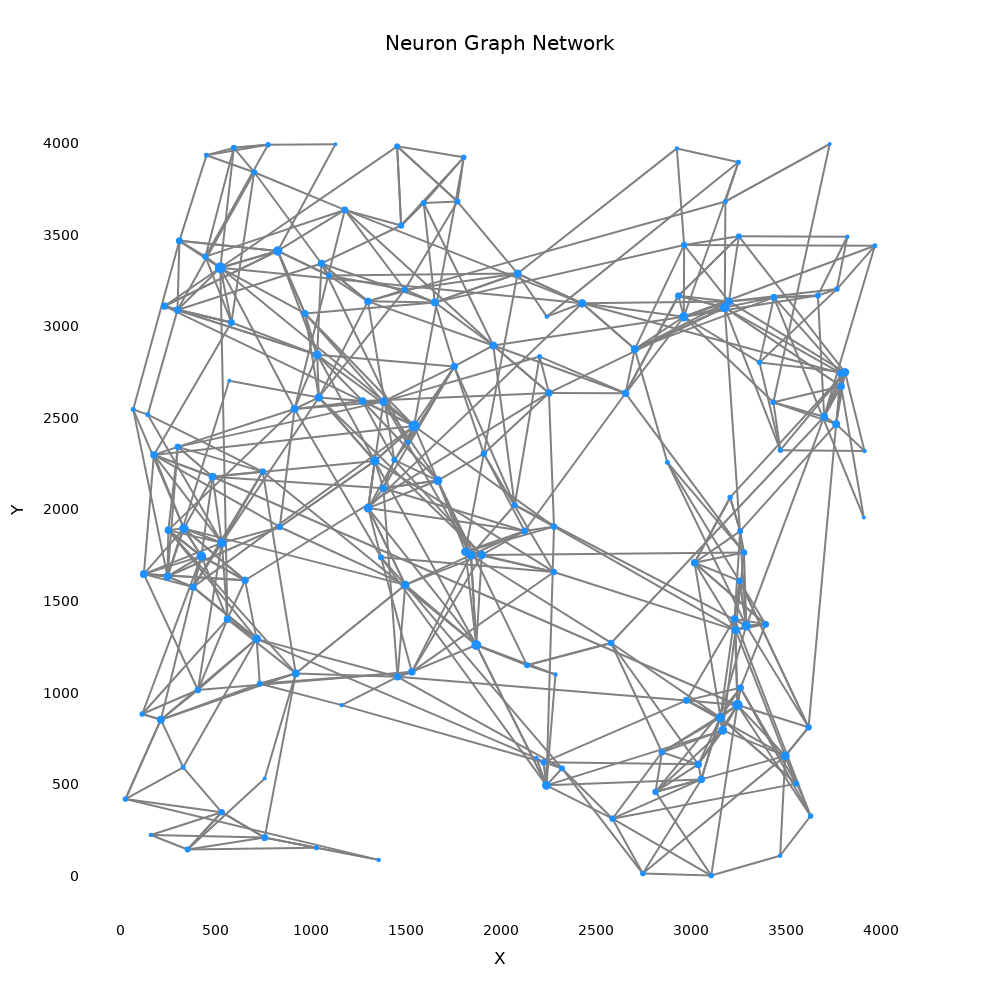

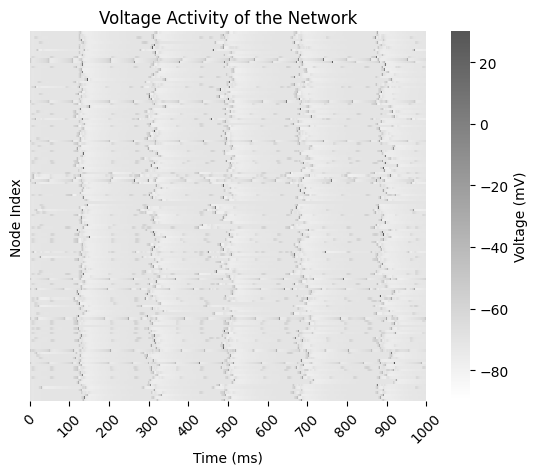

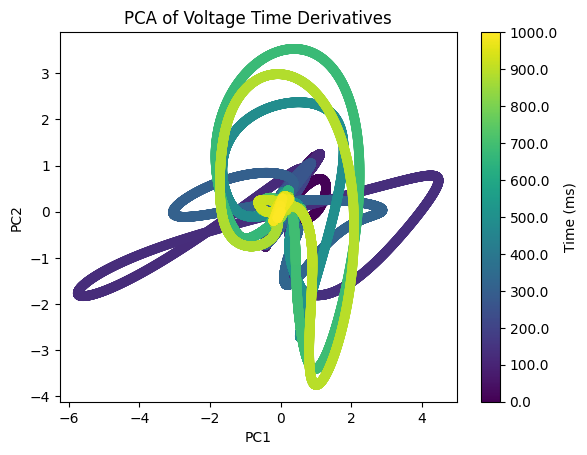

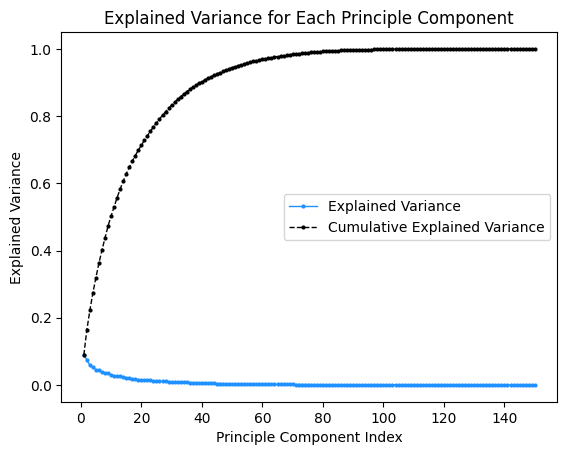

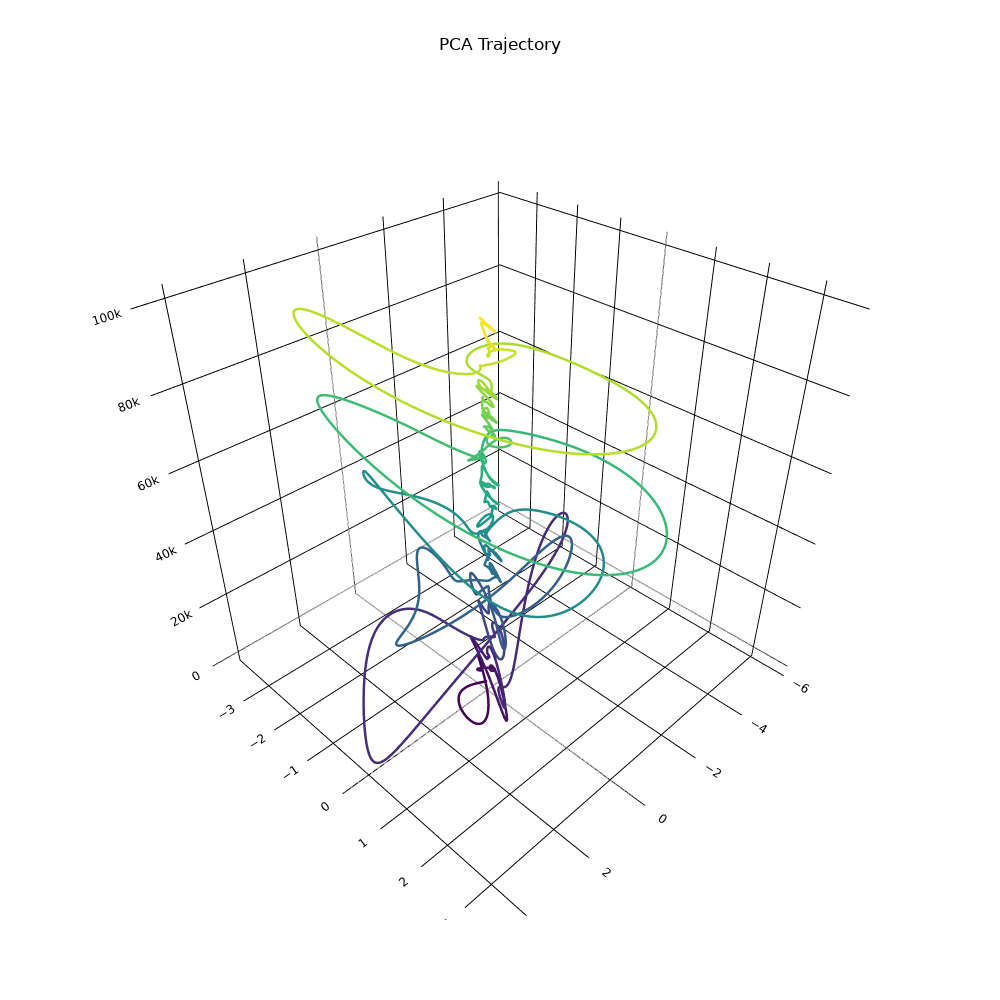

In [5]:
# Define an array ID so that I can save the data under this concept
array_id = 2
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test without modules right now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = False

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = False,
    time_to_complete_ap = None,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 5.02%
Adjacency Matrix:


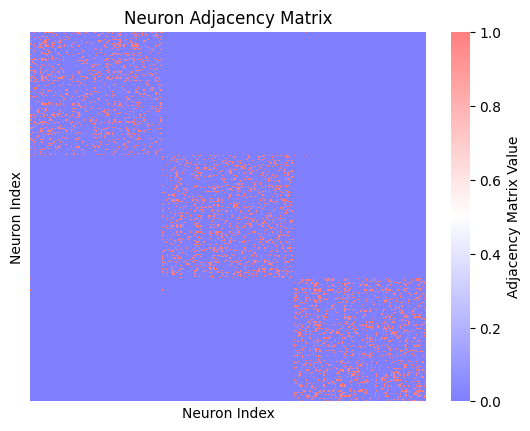



Network Configuration:


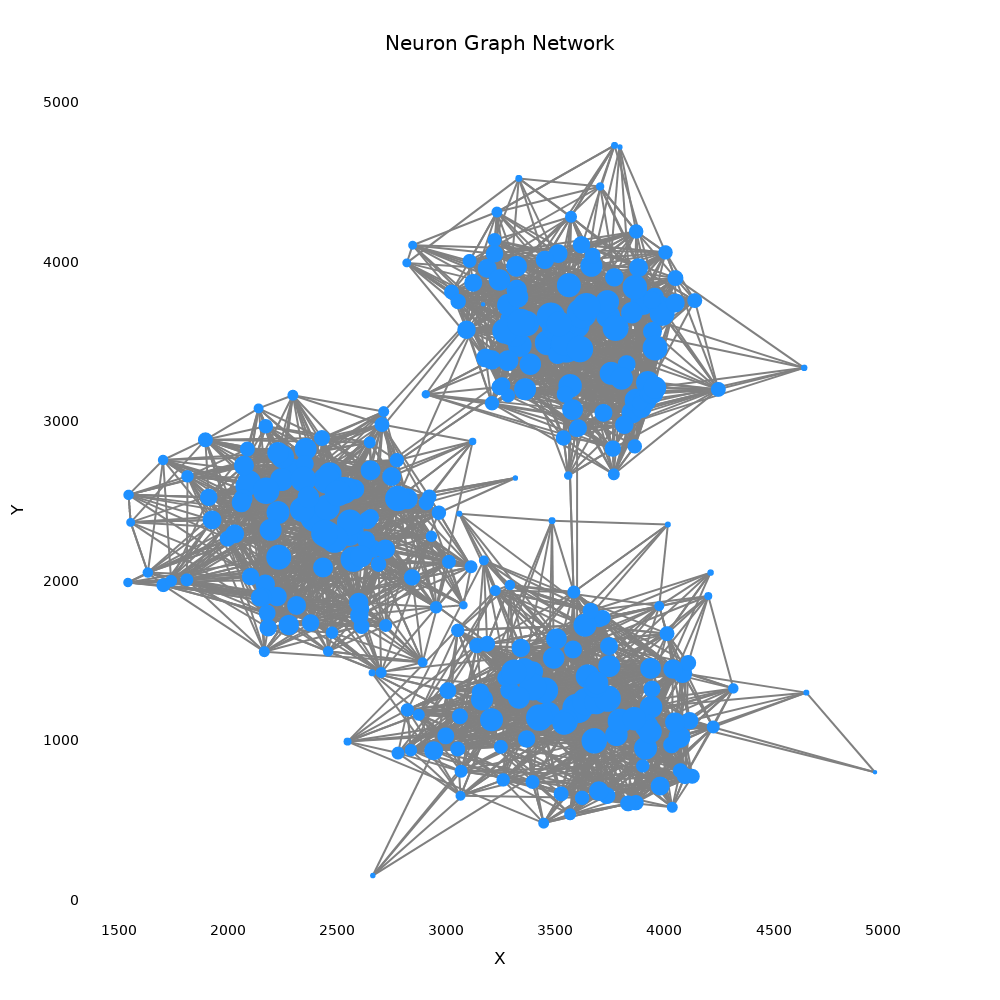

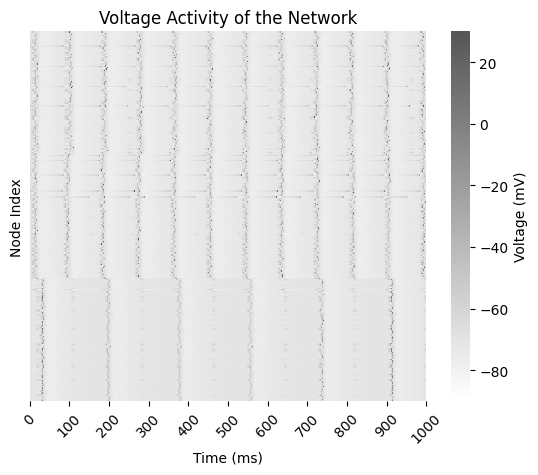

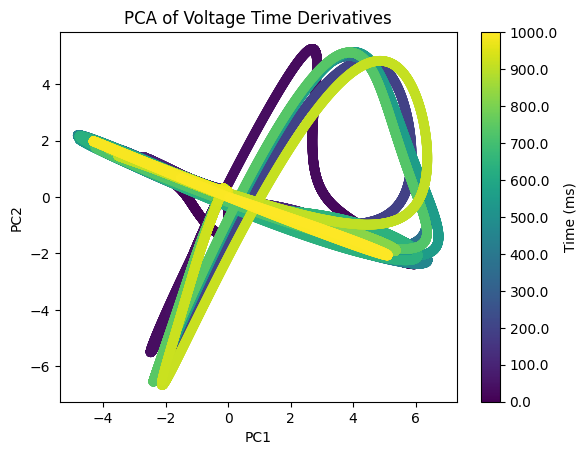

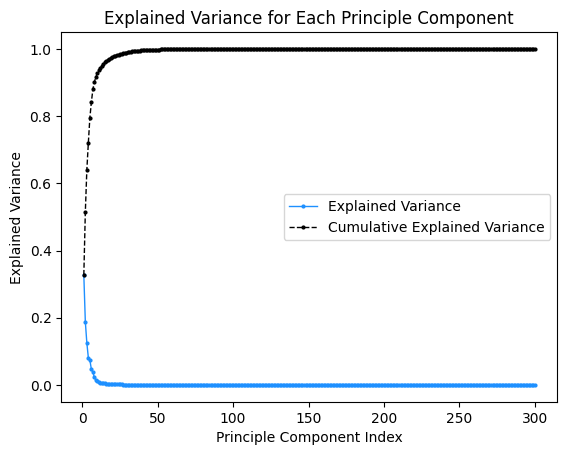

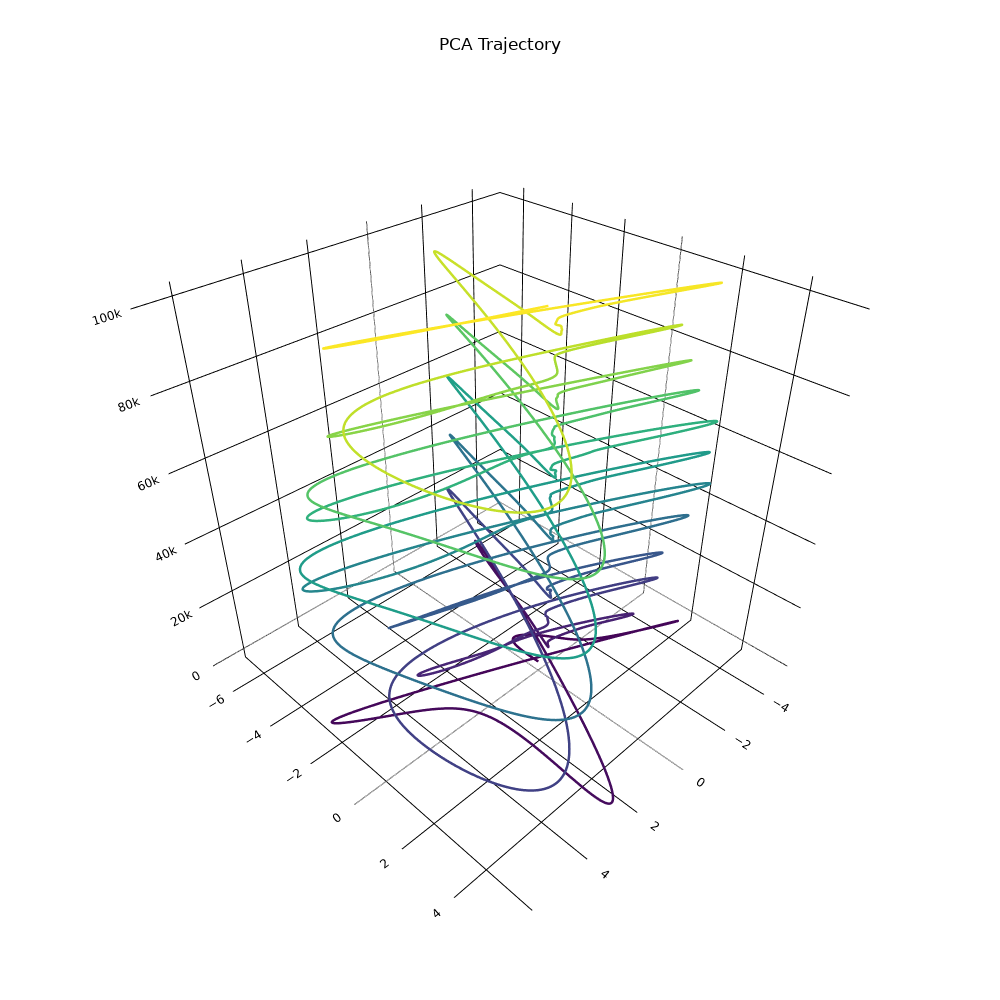

In [6]:
# Define an array ID so that I can save the data under this concept
array_id = '3-1'
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test without modules right now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = False

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = False,
    time_to_complete_ap = None,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 3.11%
Adjacency Matrix:


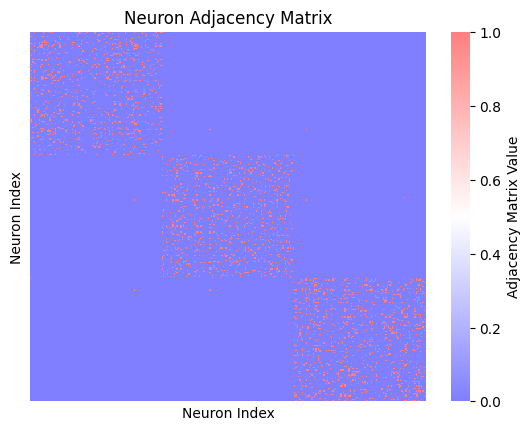



Network Configuration:


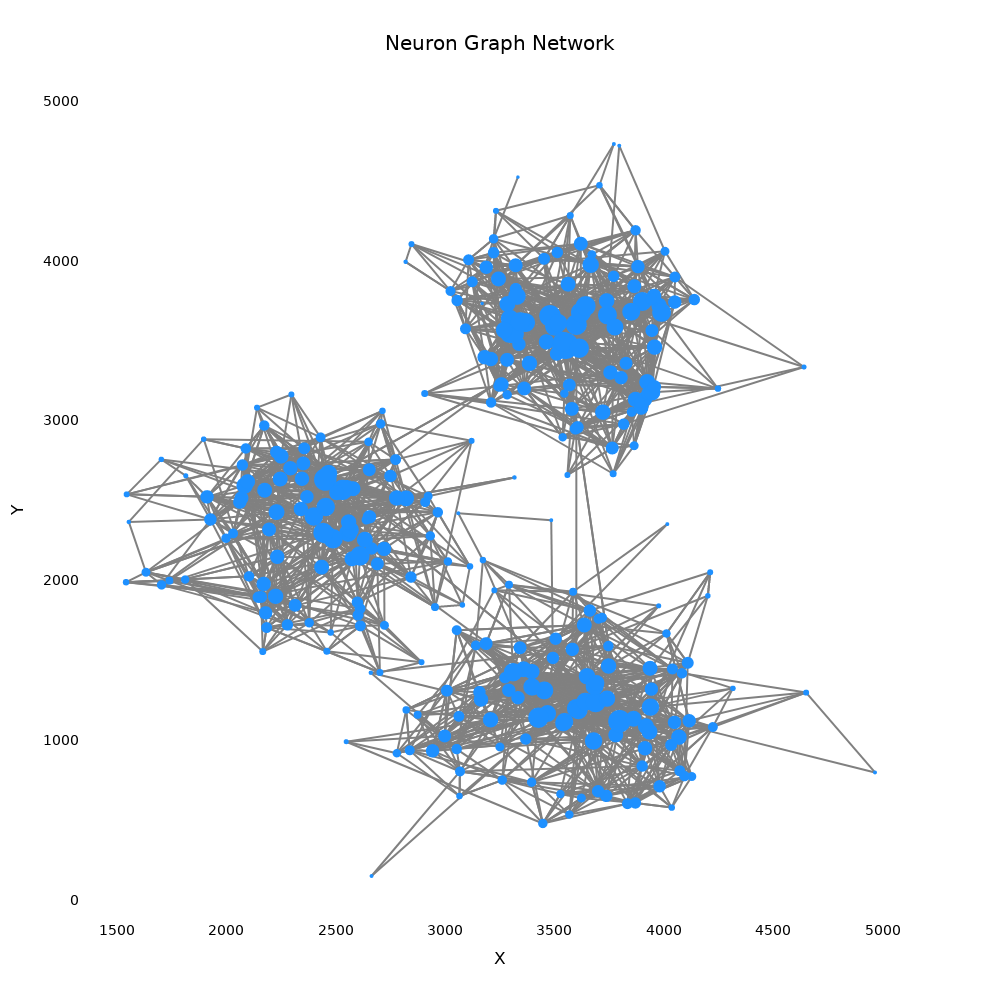

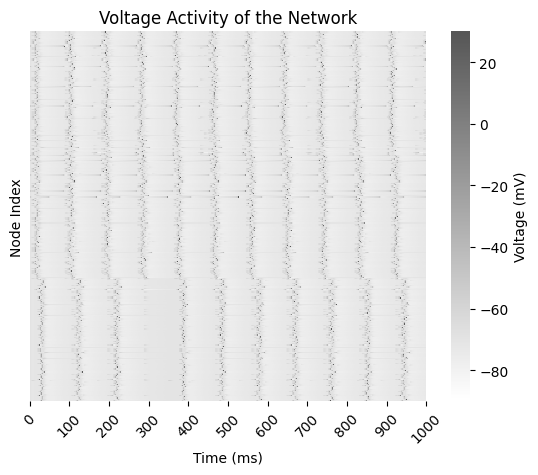

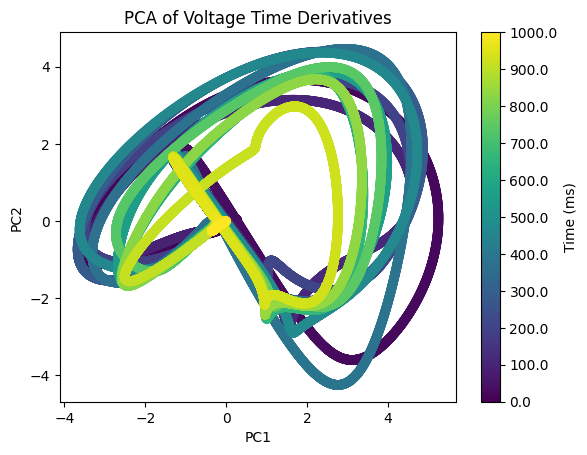

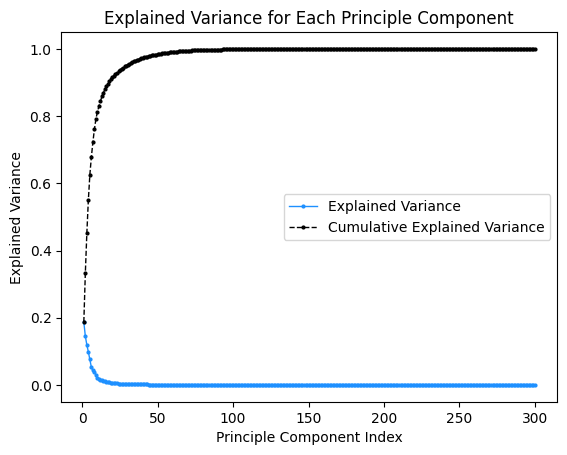

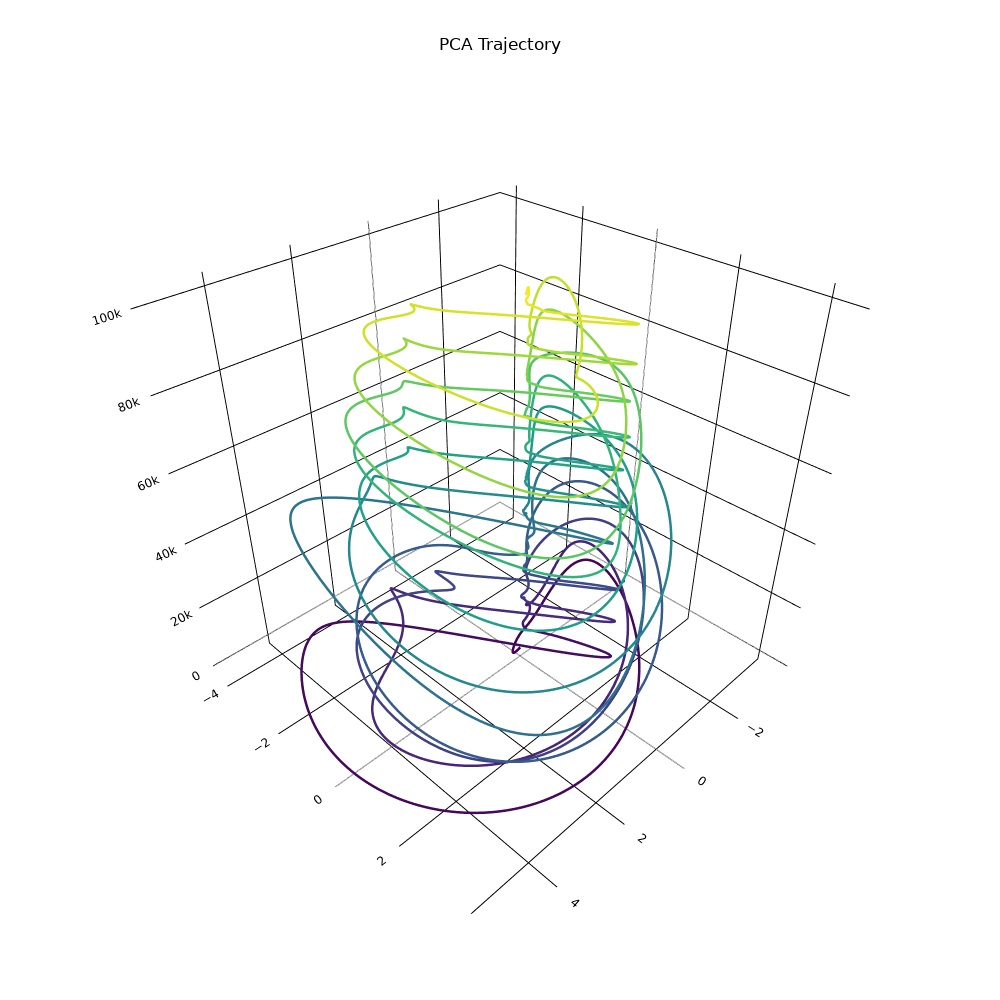

In [7]:
# Define an array ID so that I can save the data under this concept
array_id = 3
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

#### CHANGING THE ALPHA VALUE FOR CONNECTION PROBABILTIES
distance_connection_probability_exponent_constant_for_modules = 28

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test without modules right now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = False

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules, #### CHANGES FOR MODULES
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = False,
    time_to_complete_ap = None,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 2.59%
Adjacency Matrix:


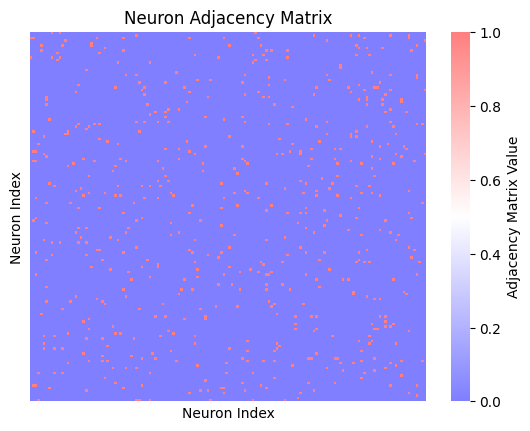



Network Configuration:


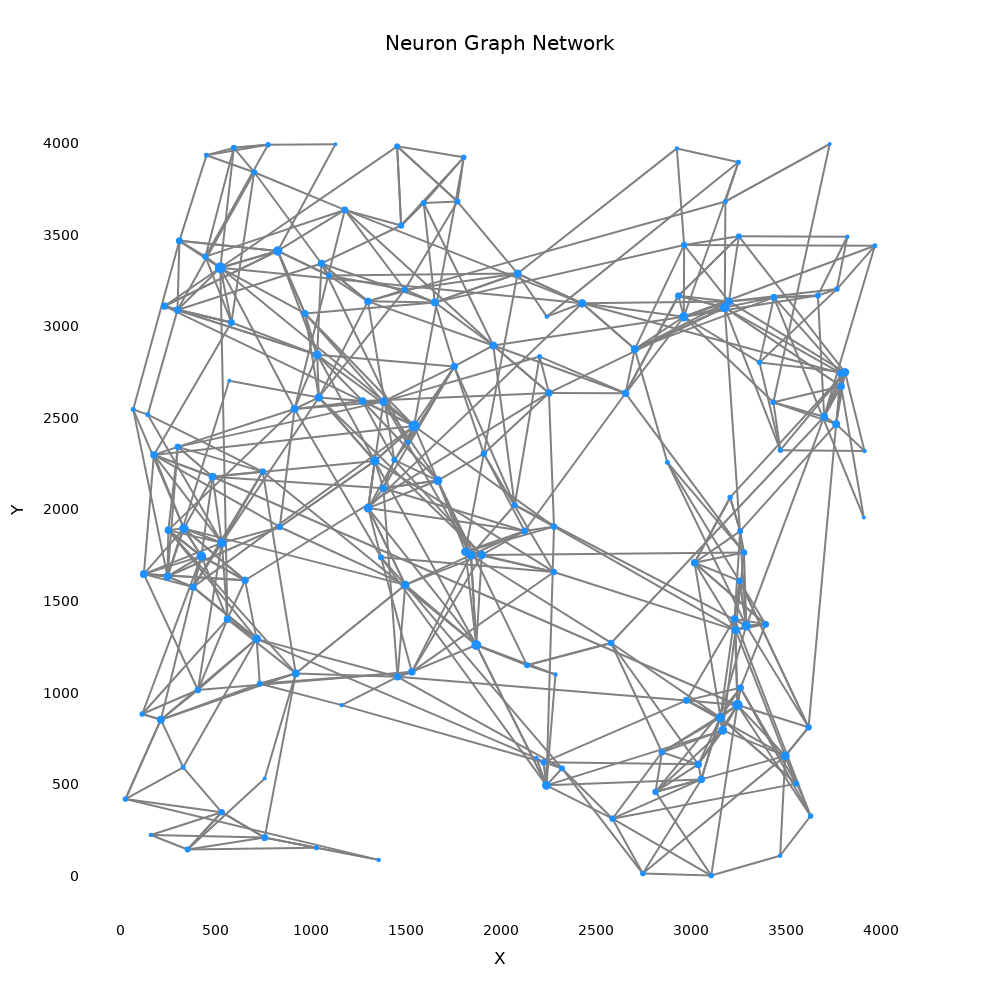

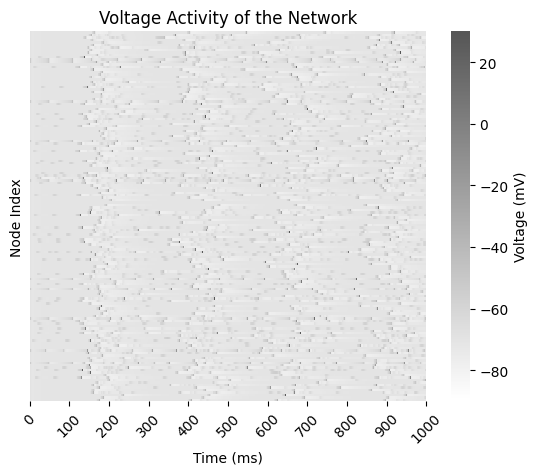

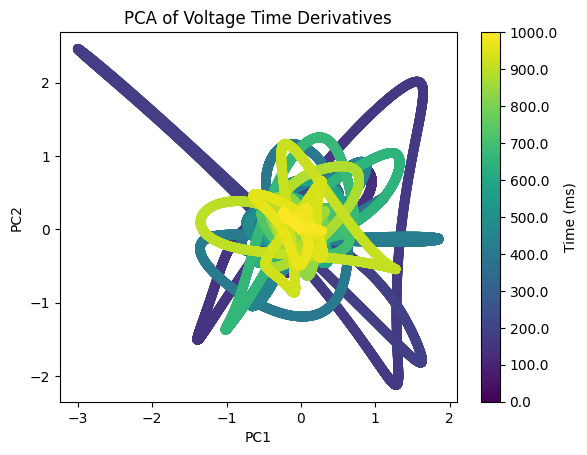

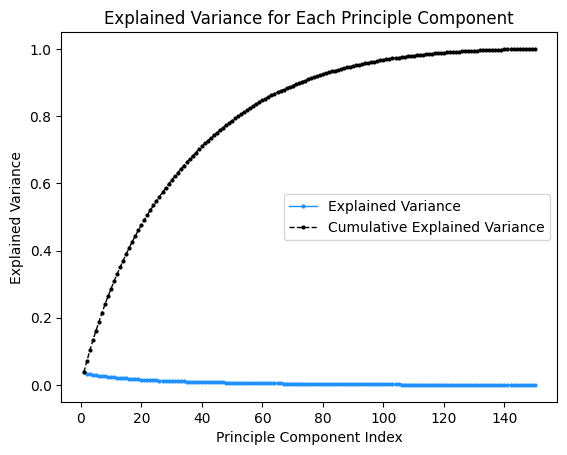

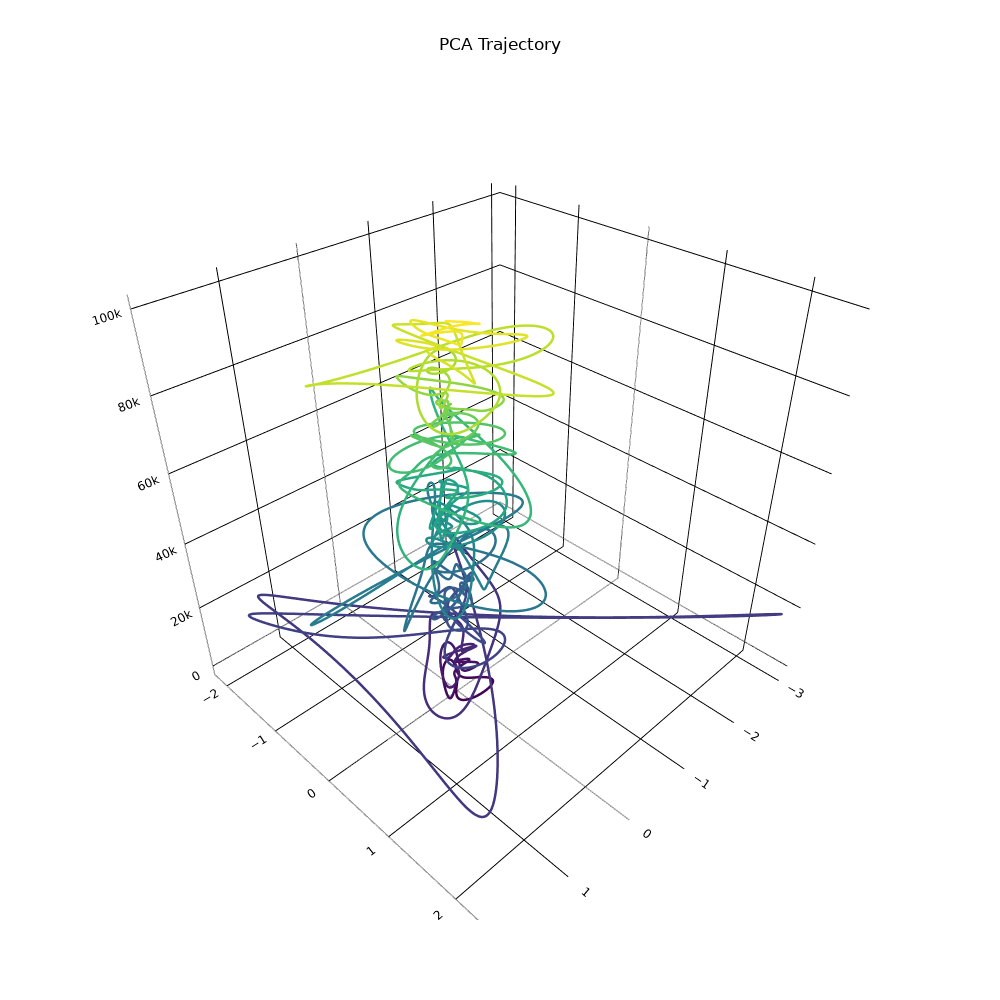

In [8]:
# Define an array ID so that I can save the data under this concept
array_id = 4
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test without modules right now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = True # Implementing timing now
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = True

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = implement_timing,
    time_to_complete_ap = NetworkTuple.time_to_complete_ap,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 3.11%
Adjacency Matrix:


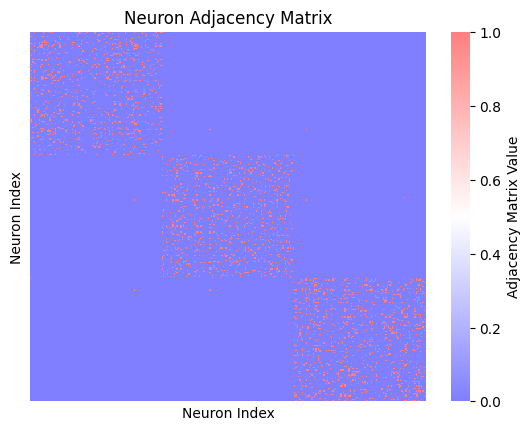



Network Configuration:


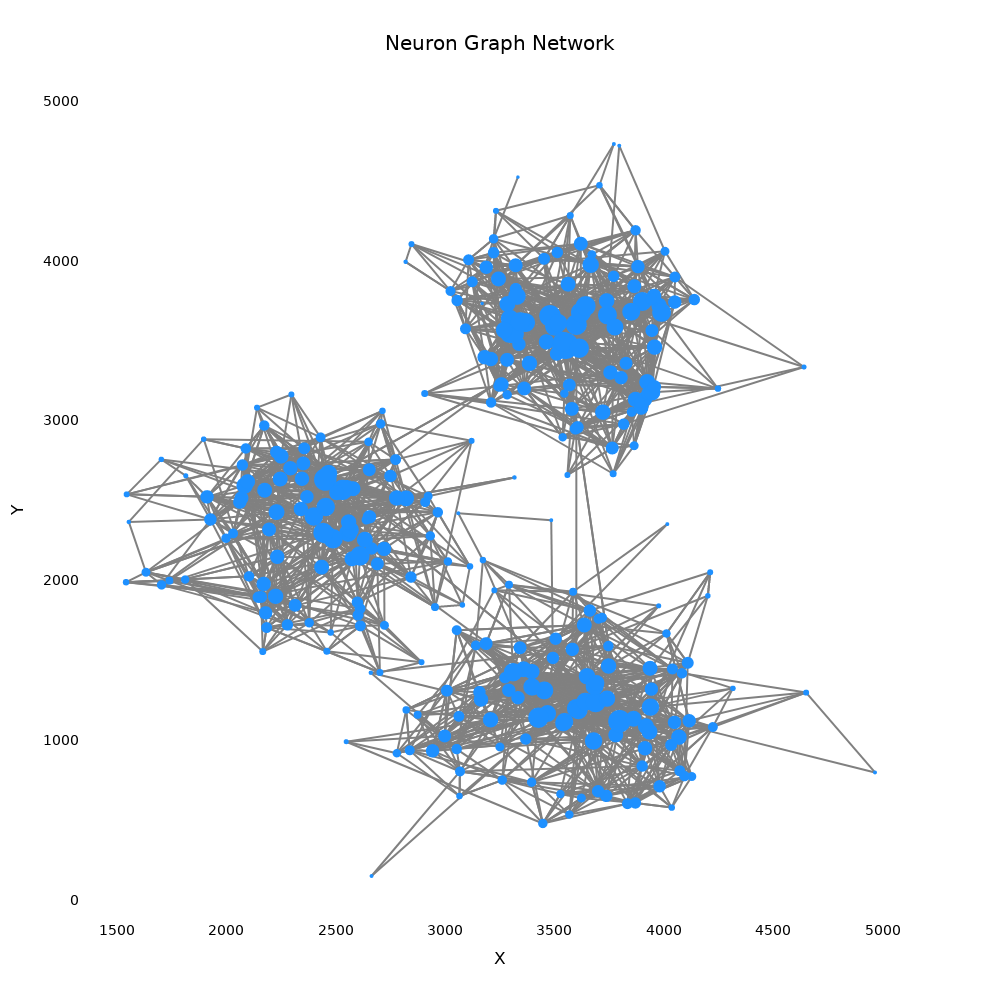

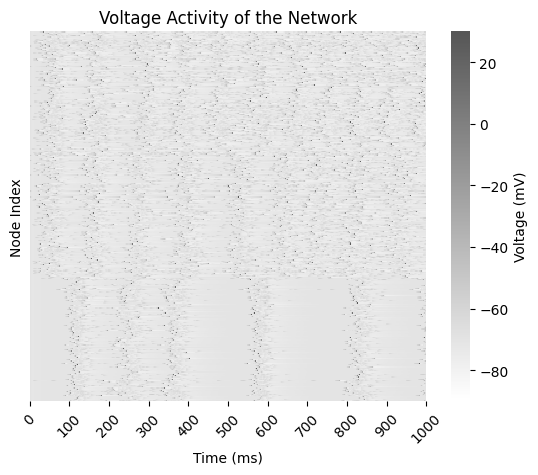

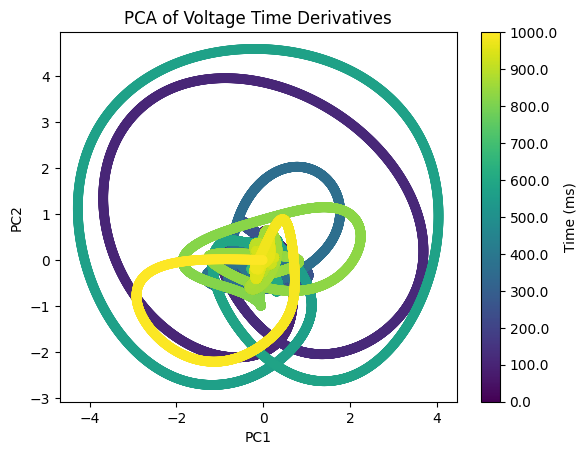

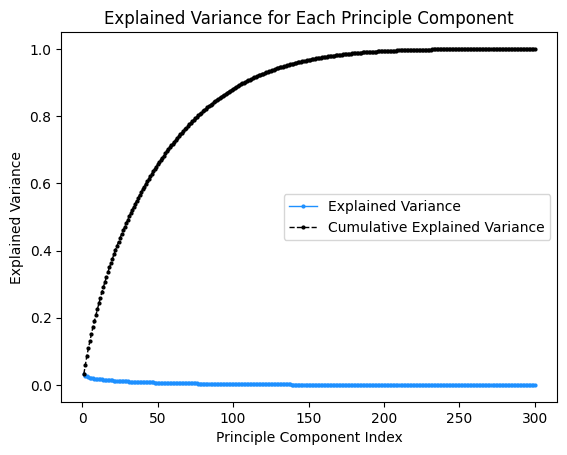

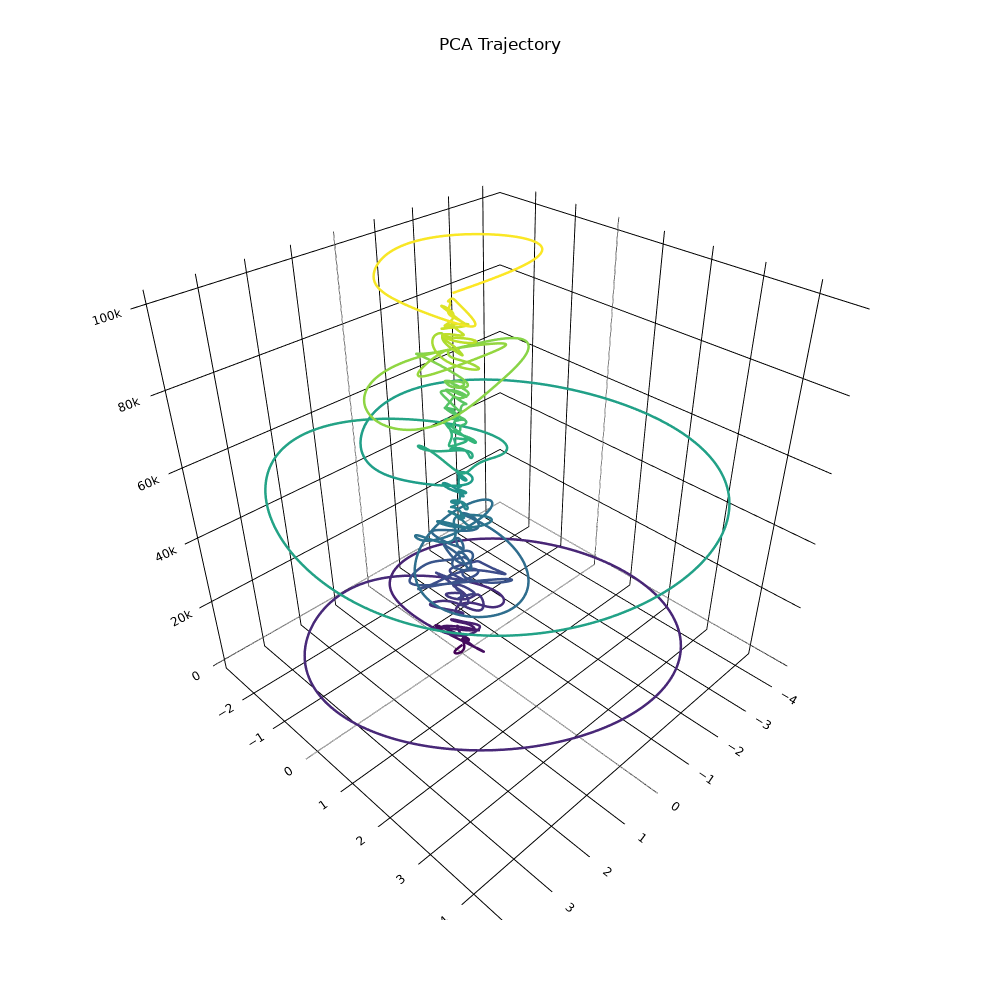

In [9]:
# Define an array ID so that I can save the data under this concept
array_id = 5
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules right now
implement_neuron_modules_connections = True # We want connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = True # Implementing timing now
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = True

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules, ### WORKING WITH MODULES NOW
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = implement_timing,
    time_to_complete_ap = NetworkTuple.time_to_complete_ap,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 2.59%
Adjacency Matrix:


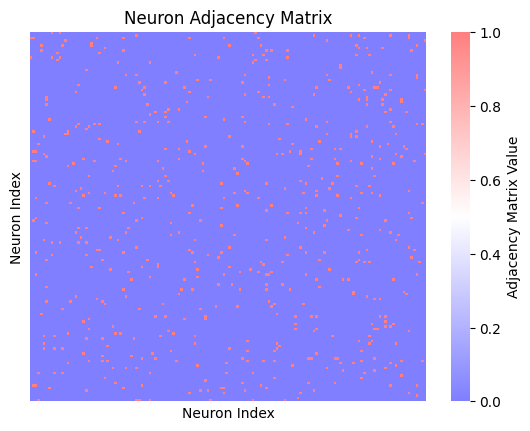



Network Configuration:


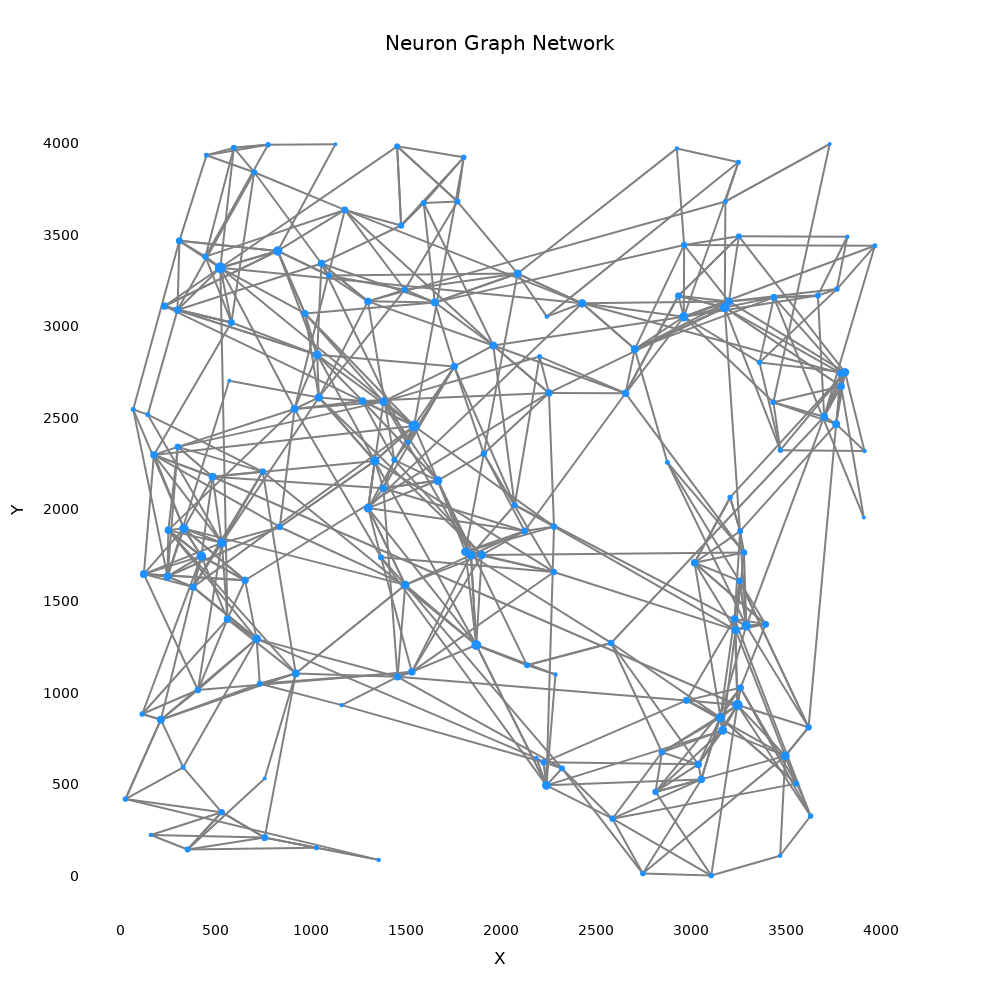

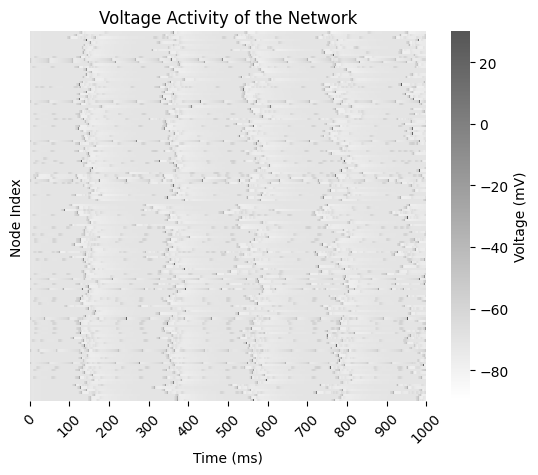

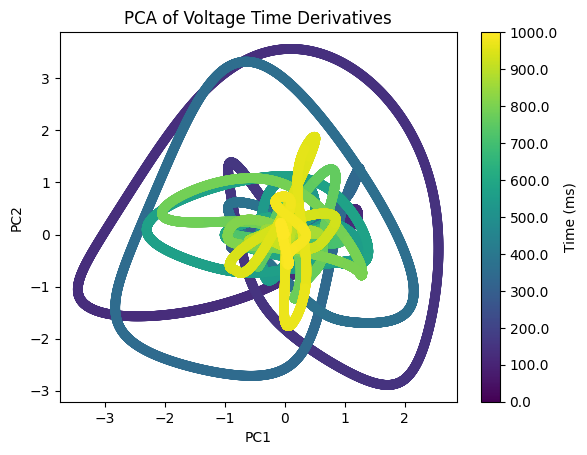

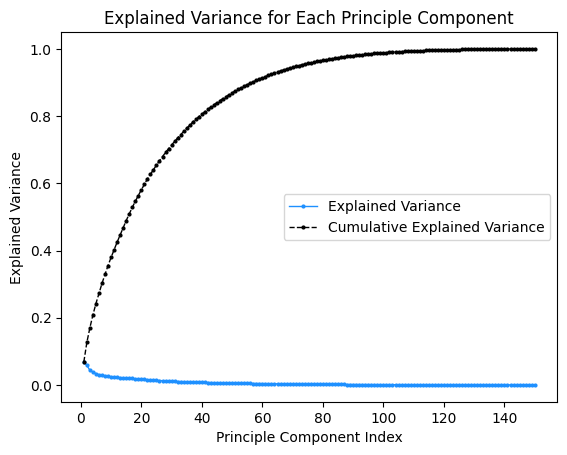

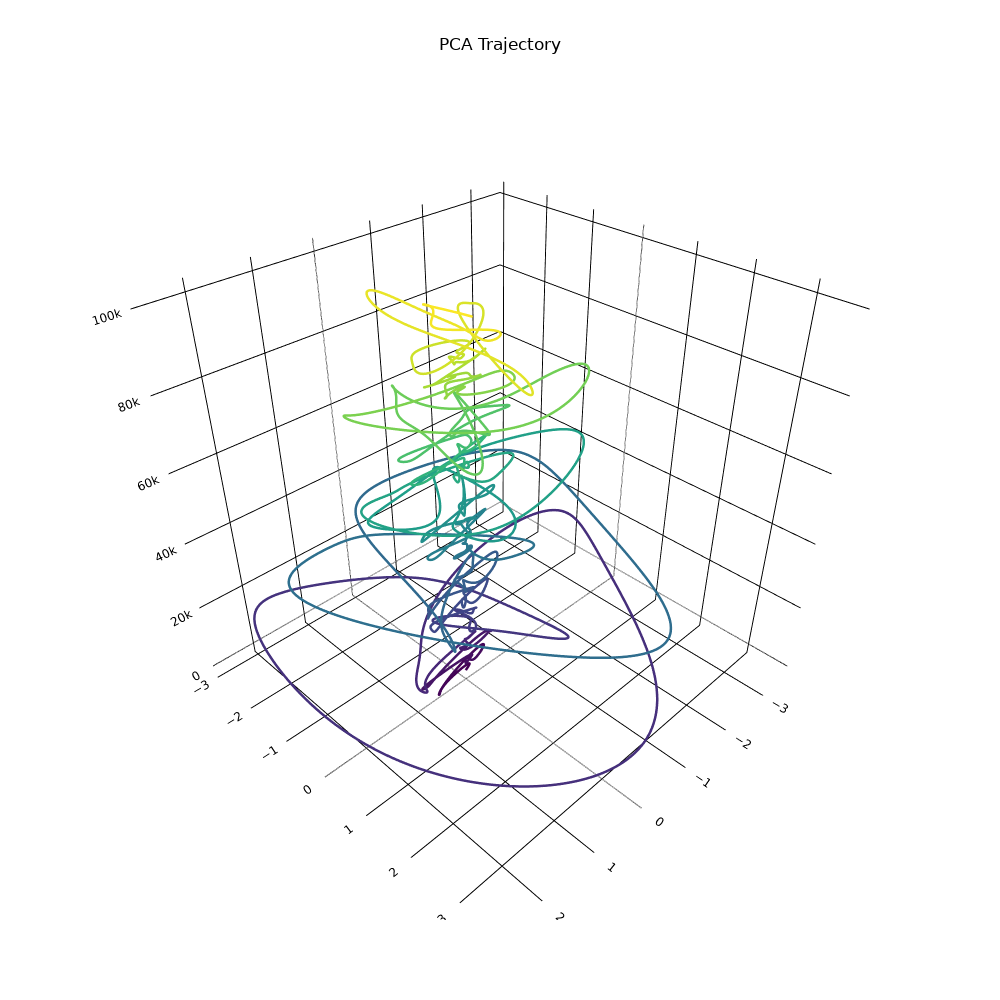

In [10]:
# Define an array ID so that I can save the data under this concept
array_id = 6
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test without modules right now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = True # Implementing timing now
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = False

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = implement_timing,
    time_to_complete_ap = NetworkTuple.time_to_complete_ap,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)

Network Density: 3.11%
Adjacency Matrix:


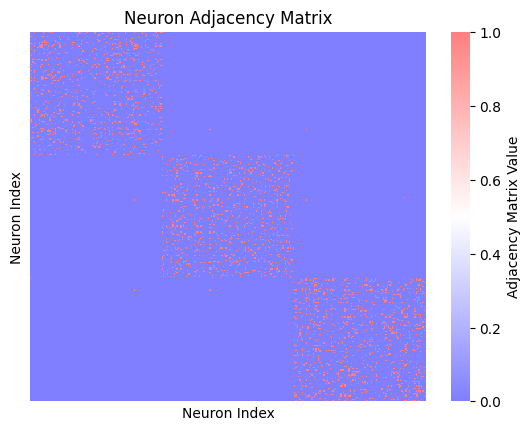



Network Configuration:


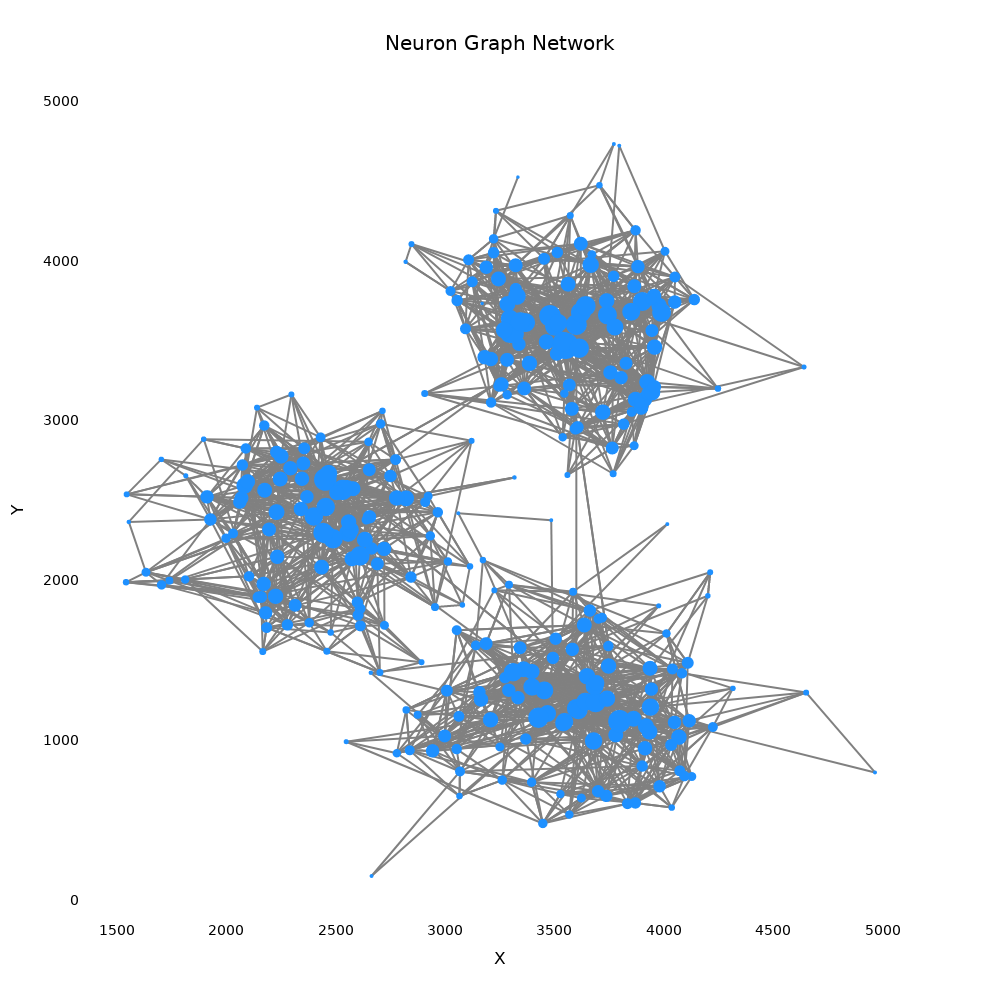

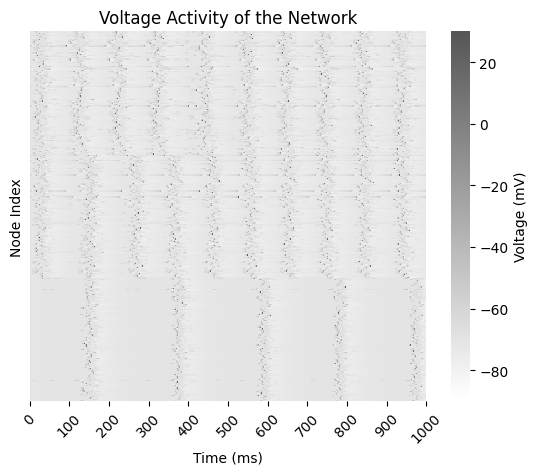

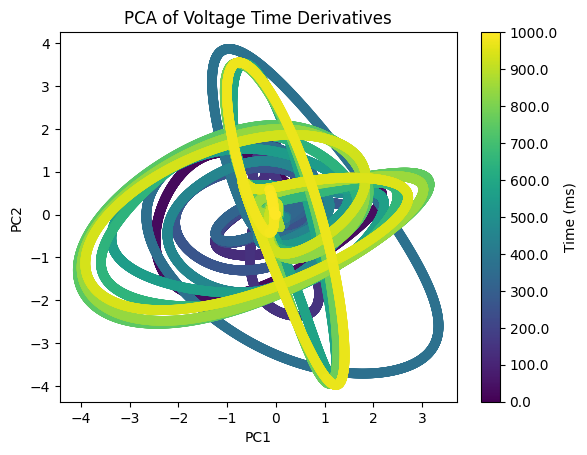

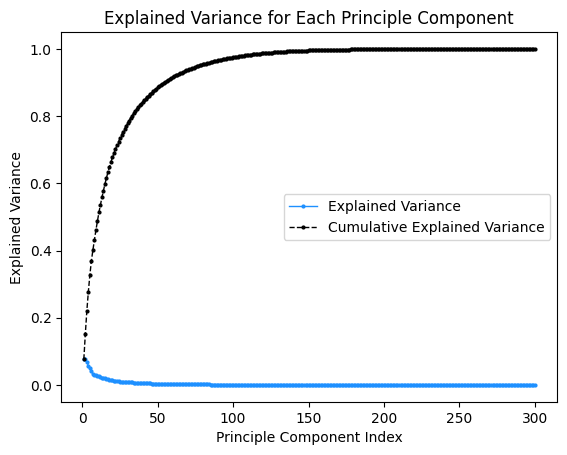

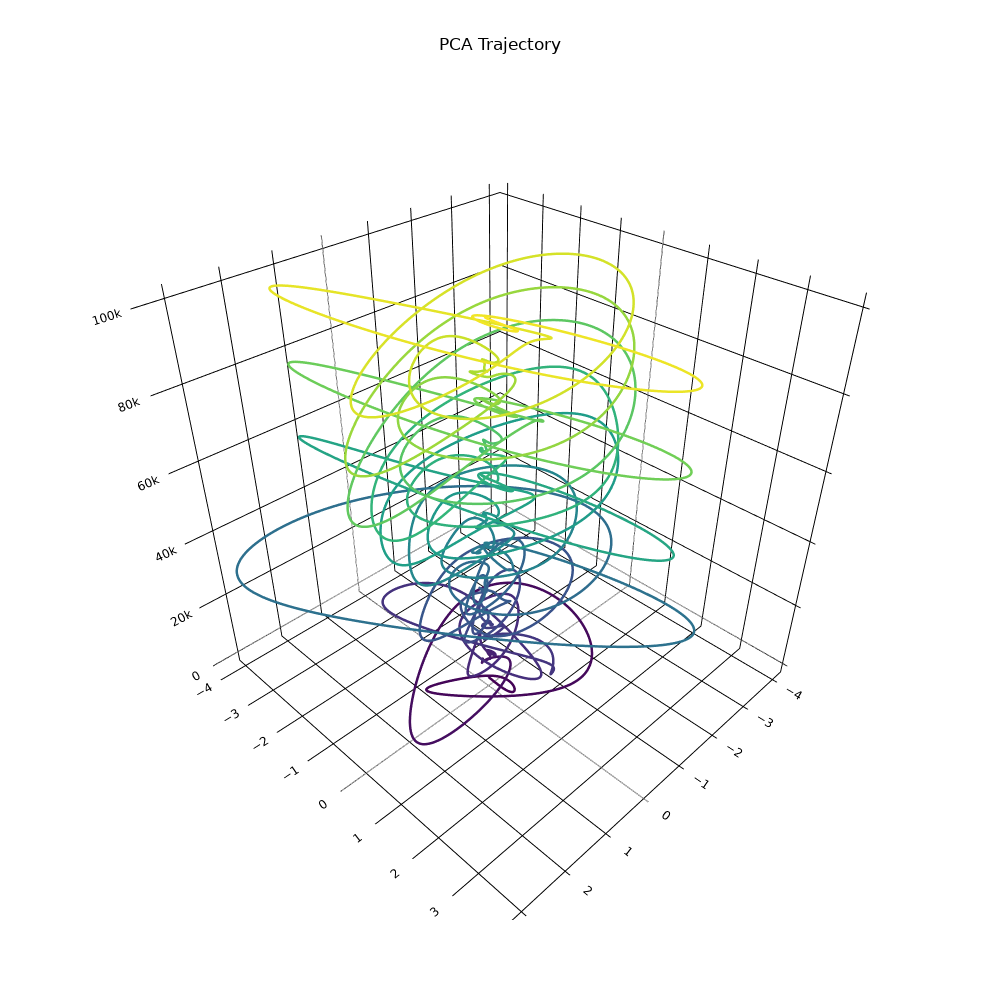

In [11]:
# Define an array ID so that I can save the data under this concept
array_id = 7
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules right now
implement_neuron_modules_connections = True # We want connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = True # Implementing timing now
implement_constant_weights = True # Want constant weights from now on with the conductance changes
constant_connection_probability = None # We want to use the exponential connection probability based on distance
constant_weight_value = 1 # Weights are 1
vary_neuron_type = False # Keep all neurons as the same
constant_diameter = False

# Image path incorporating the array id
adjacency_matrix_path = figures_base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = figures_base_path + f'network-graph-{array_id}.png'
spike_trace_path = figures_base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = figures_base_path + f'voltage-trace-{array_id}.png'
pca_save_path = figures_base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = figures_base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = figures_base_path + f'explained-variance-plot-{array_id}.png'

# Get the network tuple
NetworkTuple = GenerateNetworkTuple(
    config_dict = config_dict,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius,
    n = n,
    n_per_group = n_per_group,
    seed = seed,
    module_std = module_std,
    x1_mean = x1_mean,
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules, ### WORKING WITH MODULES NOW
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability,
    implement_timing = implement_timing,
    constant_diameter = constant_diameter,
    implement_constant_weights = implement_constant_weights,
    constant_weight_value = constant_weight_value,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    num_groups = 3,
    check_distance_matrix_symmetry = False
)

# Run the Brian2Simulation
out = Brian2SimulateNeurons(
    pos_array = NetworkTuple.pos_array,
    edges = NetworkTuple.edges,
    config_dict = config_dict,
    weights = NetworkTuple.A, 
    implement_timing = implement_timing,
    time_to_complete_ap = NetworkTuple.time_to_complete_ap,
    constant_injected_current_index = constant_injected_current_index,
)

# Plot the voltage values
PlotVoltageTrace(
    out, cmap = 'grey_r',
    flip_axes=True, save_graphic_path = voltage_trace_path
)

# Plot the PCA results
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma * 10) # Need to multiply by 10 because the t_step_size is smaller
PlotPCA(out, x_reduced, file_save_path = pca_save_path, time_tick_interval = 10000)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, out.num_time_steps, save_filepath = pca_trajectory_path)